## Staph data
http://users-birc.au.dk/cstorm/courses/MLiB_f14/project1.html

In [2]:
import requests
import numpy as np
import pandas as pd
import re
from itertools import groupby
import pickle

In [3]:
staph_url = ["http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/genome1.fa",
            "http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/genome2.fa",
           "http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/genome3.fa"]
staph_annot = ["http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/annotation1.fa",
              "http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/annotation2.fa"
              "http://users-birc.au.dk/cstorm/courses/MLiB_f14/projects/project3/annotation3.fa"]

## Load/ Modify Data

In [3]:
def load_file(url,genome=True):
    """input: url for genome, 
    output: pulled data without header and as a single txt string"""
    data = ''.join(requests.get(url).text.split("\n")[1::])
    return data

def segment_genome(data_string,split_size):
    """input: genome data string (data_string) and then size we should split the data (split_size)
    output: array split by specified split_size"""
    chunks = len(data_string)
    data = [data_string[i:i+split_size] for i in range(0,chunks,split_size)]
    return data

def gene_label(annotation, min_gene=10):
    """Input: annotation
    ouput: the label array for data (true if C or R else false for > 50% of line)"""
    size = len(annotation[0])
    print(size)
    label = [True if len(line.strip("C")) < size/2 or len(line.strip("R")) < size/2 else False 
             for line in annotation]
    return label

def gene_label_dir(annotation,direction="C"):
    """Input: annotation and direction is C (forward) unless specified as R (reverse)
    ouput: the label array for data"""
    size = len(annotation[0])
    label = [True if len(line.strip(direction)) < size/2 else False 
             for line in annotation]
    return label

def nucleotide_frequency(seq):
    '''Count the occurrences of characters in "seq".'''
    counts = {'A':0,'C':0,'G':0,'T':0}
    for c in seq:
        counts[c] +=1
    total = sum(list(counts.values()))
    for key, value in counts.items():
        counts[key] = value / total
    return counts

In [4]:
import re

def ORF_finds(seq):
    """input: A sequence string (the genome) is taken and all the ATG's in the sequence are found
    output: a list of start indices 
    *** on this reverse strand... these are from the end of the sequence!!"""
    starts = [m.start() for m in re.finditer('ATG', seq)]
    return starts

def sequence_list(genome,ends,start):
    """input: output: """
    sequences = [genome[start:start+end+3] for end in ends[0]]
    sequences += [genome[start:start+end+3] for end in ends[1]] 
    sequences += [genome[start:start+end+3] for end in ends[2]]
    return sequences

def sequence_list2(genome,ends,start,direction):
    """input: """
    frame = start % 3
    sequences = [(start, start+end+3, 'taa', frame, direction) for end in ends[0]]
    sequences += [(start, start+end+3, 'tag', frame, direction) for end in ends[1]] 
    sequences += [(start, start+end+3, 'tga', frame, direction) for end in ends[2]]
    return sequences

# def geneList(genome,direction):
#     """input: genome (character string), which direction we are looking at (the forward or reverse strand)
#     output: a list of sequences on that particular strand of interest (forward or reverse complement)"""
#     if direction == 'R':
#         genome = reverse_complement(genome)
#     starts = ORF_finds(genome)
#     sequences = []
#     for start in starts:
#         ## m.start()+1 so that when we sample the sequence we go from 
#         ends = [[m.start() for m in re.finditer(x, genome[start:start+2000]) if m.start() % 3 == 0] for x in ["TAA", "TAG", "TGA"]]
#         if direction == 'R':
#             length = len(genome)
#             start = length - 3 - start  # CAT ~ ATG (length - 1 - 2)
#             ends = [[length - e for e in end] for end in ends]
#         sequences.append(sequence_list2(genome,ends,start,direction))
#     return sequences 

def geneList(genome,direction):
    """input: genome (character string), which direction we are looking at (the forward or reverse strand)
    output: a list of sequences on that particular strand of interest (forward or reverse complement)"""
    starts = ORF_finds(genome)
    sequences = []
    for start in starts:
        ## m.start()+1 so that when we sample the sequence we go from 
        ends = [[m.start() for m in re.finditer(x, genome[start:start+2000]) if m.start() % 3 == 0] for x in ["TAA", "TAG", "TGA"]]
        sequences.append(sequence_list2(genome,ends,start,direction))
    return sequences   

def fixed(possible_reverse_sequences, genome_length):
    fixed_reversed_sequences = []
    for possible_reverse in possible_reverse_sequences:
        f = [(genome_length - end , genome_length - start,end_codon,frame,strand) for start,end,end_codon,frame,strand in possible_reverse]
        fixed_reversed_sequences.append(f)
    return fixed_reversed_sequences

def potentialGenes(genome):
    """input: genome which is a string of a's, t's, g's, c's
    ouput: the number of possible genes that start with ATG and 
    end with taa,tag, or tga on the forward and reverse complement DNA strand"""
    forwards = geneList(genome,'F')
    reversed_genome = reverse_complement(str(genome))
    reverse = geneList(reversed_genome,'R')
    reverses = fixed(reverse, len(genome))
    combos = forwards + reverses
    return combos

In [5]:
def reverse_complement(genome):
    """input: genome, output: reverse complement"""
    switch = {"A":"T","G":"C","T":"A","C":"G"}
    rc = ''.join([switch[letter] for letter in genome])[::-1]
    return rc

In [197]:
##Convert sequences in to amino acid sequences
def tri_split(seq):
    return ''.join([char+' ' if (i+1) % 3 == 0 else char for i,char in enumerate(seq)]).split()
def codonToAA(codon_list):
    aa_seq = ''.join([codon_to_aa[codon] for codon in codon_list])
    return aa_seq
def aa_frequency(seq):
    """Count the occurrences of amino acids in "seq"."""
    zeros = [0]*len(aa)
    counts = dict(zip(aa, zeros))
    for c in seq:
        counts[c] +=1
        
    total = sum(list(counts.values()))
    for key, value in counts.items():
        counts[key] = value / total
    return counts

def no_prior_stops(aa_seq):
    prior = aa_seq[0:len(aa_seq)-1]
    if 'x' in prior:
        return False
    else:
        return True

In [6]:
codon_map = {"I":["ATT", "ATC", "ATA"],"L":["CTT", "CTC", "CTA", "CTG", "TTA","TTG"],
          "V":["GTT", "GTC", "GTA", "GTG"],"F":["TTT", "TTC"],"M":["ATG"],"C":["TGT", "TGC"],
          "A":["GCT", "GCC", "GCA", "GCG"],"G":["GGT", "GGC", "GGA", "GGG"],
          "P":["CCT", "CCC", "CCA", "CCG"],
          "T":["ACT", "ACC", "ACA", "ACG"],"S":["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
          "Y":["TAT", "TAC"],"W":["TGG"],"Q":["CAA", "CAG"],"N":["AAT", "AAC"],"H":["CAT", "CAC"],
             "E":["GAA", "GAG"],"D":["GAT", "GAC"],"K":["AAA", "AAG"],
             "R":["CGT", "CGC", "CGA", "CGG","AGA", "AGG"],"X":["TAA", "TAG", "TGA"]}

def invert(d):
    return dict( (v,k) for k in d for v in d[k] )

codon_to_aa = invert(codon_map)

def codonToAA(strand):
    aa_seq = ''.join([codon_to_aa(codon) for codon in strand])
    return aa_seq

In [7]:
## amino acid to nucleotide chart http://www.cbs.dtu.dk/courses/27619/codon.html
## X === stop
aa = ["I","L","V","F","M","C","A","G","P","T","S","Y","W","Q","N","H","E","D","K","R","X"]
aa_name = ["Isoleucine","Leucine","Valine","Phenylalanine","Methionine","Cysteine","Alanine",
           "Glycine","Proline","Threonine","Serine","Tyrosine","Tryptophan",
           "Glutamine","Asparagine","Histidine","Glutamic_acid", "Aspartic_acid", 
           "Lysine","Arginine","Stop_codons"]
codons = [["ATT", "ATC", "ATA"],["CTT", "CTC", "CTA", "CTG", "TTA"," TTG"],
          ["GTT", "GTC", "GTA", "GTG"],["TTT", "TTC"],["ATG"],["TGT", "TGC"],
          ["GCT", "GCC", "GCA", "GCG"],["GGT", "GGC", "GGA", "GGG"],
          ["CCT", "CCC", "CCA", "CCG"],
          ["ACT", "ACC", "ACA", "ACG"],["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
          ["TAT", "TAC"],["TGG"],["CAA", "CAG"],["AAT", "AAC"],["CAT", "CAC"],["GAA", "GAG"],
          ["GAT", "GAC"],["AAA", "AAG"],["CGT", "CGC", "CGA", "CGG","AGA", "AGG"],
          ["TAA", "TAG", "TGA"]]

codon_map = {"I":["ATT", "ATC", "ATA"],
             "L":["CTT", "CTC", "CTA", "CTG", "TTA"," TTG"],
             "V":["GTT", "GTC", "GTA", "GTG"],
             "F":["TTT", "TTC"],"M":["ATG"],
             "C":["TGT", "TGC"],
             "A":["GCT", "GCC", "GCA", "GCG"],
             "G":["GGT", "GGC", "GGA", "GGG"],
             "P":["CCT", "CCC", "CCA", "CCG"],
             "T":["ACT", "ACC", "ACA", "ACG"],
             "S":["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
             "Y":["TAT", "TAC"],
             "W":["TGG"],
             "Q":["CAA", "CAG"],
             "N":["AAT", "AAC"],
             "H":["CAT", "CAC"],
             "E":["GAA", "GAG"],
             "D":["GAT", "GAC"],
             "K":["AAA", "AAG"],
             "R":["CGT", "CGC", "CGA", "CGG","AGA", "AGG"],
             "Stop":["TAA", "TAG", "TGA"]}

codon_properties_map = {}

In [8]:
## Thermofisher aa properties table
from lxml import html
def pull_page(url):
    data = requests.get(url).text
    return data
tag = "table table-bordered table-striped"
tag = "table"
url = "https://www.thermofisher.com/us/en/home/life-science/protein-biology/protein-biology-learning-center/protein-biology-resource-library/pierce-protein-methods/amino-acid-physical-properties.html"

page = html.fromstring(pull_page(url))
tables = page.cssselect(tag)
aa_table = pd.read_html(html.tostring(tables[0]),header=0)[0]


### aa_properties
Aliphatic: Alanine,Isoleucine,Leucine,Valine
Aromatic: Phenylalanine, Tryptophan, Tyrosine
Polar_neutral: Asparagine, Cysteine, Glutamine, Methionine,Serine,Threonine
charged: Aspartic acid, Glutamic acid
    
Properties table
https://www.thermofisher.com/us/en/home/life-science/protein-biology/protein-biology-learning-center/protein-biology-resource-library/pierce-protein-methods/amino-acid-physical-properties.html

http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3456822/pdf/10867_2004_Article_396406.pdf

http://www.proteinstructures.com/Structure/Structure/amino-acids.html

In [9]:
# flipped_annot = annot[::-1]

def check_gene_state(loc,annot,strand):
    """input: output: """
    start, end = int(loc[0]), int(loc[1])
    fwd = list(set(annot[start:end+1]))
    bhd = list(set(annot[start - 1:end]))
    if strand == 'F':
        states = list(set(annot[start:end]))
        state = 'C'
    else:
        r_annot = flipped_annot
        states = list(set(r_annot[start:end]))
        state = 'R'
    if len(states) == 1 and states[0] == state and len(fwd) != 1 and len(bhd) != 1:
        return True
    else:
        return False

In [10]:
def build_training_data(annot, data):
    """This finds all the genes, non-coding regions, 
    reverse regions in the genome and returns them as a list
    annot is the annotated genome with c's as forward genes, 
    n's as noncoding regions and r's as genes on the reverse complement strand. 
    data is the genome comprised of a's,t's,g's,c's. 
    Both annot and data are strings"""
    d = []
    i = 0
    c = ''
    start = 0
    while i < len(annot)-1:
        if str(annot[i]) != str(annot[i+1]):
            end = i
            d.append((start,end,str(c),str(annot[i-1])))
            c = ''
            start = i+1
        else:
            c = c + data[i]
        i += 1
    d.append((start,i,str(c),str(annot[i-1])))   
    return d

In [11]:
from itertools import groupby

def find_regions(annot,data):
    """This finds all the genes, non-coding regions, 
    reverse regions in the genome and returns them as a list
    annot is the annotated genome with c's as forward genes, 
    n's as noncoding regions and r's as genes on the reverse complement strand. 
    data is the genome comprised of a's,t's,g's,c's. 
    Both annot and data are strings"""
    stateGroups = groupby(enumerate(annot), lambda value: value[1])
    genome_regions = [(state, [x for x, _ in iterator]) for state, iterator in stateGroups] 
    regions = [(region[0],min(region[1]),max(region[1])+1,
                data[min(region[1]):max(region[1])+1]) for region in genome_regions]
    return regions

In [12]:
def frameShift(seq,shift):
    """input: seq and shift -- shift not used...."""
    new_seq = ''
    for j, i in enumerate(seq):
        if j % shift == 0:
            new_seq = new_seq + i + ' '
        else: 
            new_seq = new_seq + i
    return new_seq


# fs = [frameShift(seq,3) for seq in gene_df.sequence]

In [13]:
def state(annot):
    """input: states are possible annotations C forward gene,
    N - not a gene, or R for reverse gene"""
    states = list(set(annot))
    return states

def transitions(annot,state):
    """input: determine when transitions occur where annot is annotated 
    and state is the state i'm looking to transition from ouput: there location"""
    trs = list(set(annot))
    transits = {}
    total = len(annot) 

    for transition_state in trs:
        count = len([ts for i,ts in enumerate(annot[:-1]) if str(ts) == state and str(annot[i+1]) == transition_state])
        transits[str(transition_state)] = count/total
    return transits

def emissions(genome,annot,state):
    """input: genome is  a genome, annot is its annotation, 
    state is the state i want to count nucleotide frequency of"""
    ems = list(set(genome))
    
    emissions = {}
    transition_totals = {}

    total = len([letter for letter in annot if str(letter) == state])
    for emission_state in ems:
        count = len([letter for i,letter in enumerate(genome) if 
                     str(letter) == emission_state and str(annot[i])==state])
        emissions[str(emission_state)] = count/total    
    return emissions

def prior_state_emissions(genome,annot):
    """input: """
    state_dictionary = {}
    states = state(annot)
    for s in states:
        if s == 'N':
            prob = 1
        else:
            prob = 0
        em = emissions(genome,annot,s)
        tr = transitions(annot,s)
        state_dictionary[s] = [str(s),prob,em,tr]
    return state_dictionary

In [14]:
# from collections import defaultdict
def aa_find(seq):
    """find aa's in sequence
    input: sequence, 
    output: dictionary of codons in sequence"""
    codon_count = {}
    for aa, codons in codon_map.items():
        codon_count[aa] = 0
        if any(x in seq for x in codons):
            codon_count[aa] += 1
    return codon_count

In [15]:
### Pipeline

## load genome annotation
annot = load_file(staph_annot[0])

## load genome
data = load_file(staph_url[0])

## Built table of sequences for each state in genome
region = find_regions(annot,data)
# re = build_training_data(annot,data)
regions = pd.DataFrame(region)
regions.columns = [["state","start","end","seq"]]
regions.head()
print("Built table of sequences for each state in genome...")
print(regions.head(5))

## Reverse Complement strands found on the Reverse strand
regions.seq = regions.apply(lambda x: reverse_complement(x[3]) if x[0] == "R" else x[3],axis=1)
print("State 'R' sequences were reverse complemented...")

Built table of sequences for each state in genome...
  state  start   end                                                seq
0     N      0   231  TTGTTGATATTCTGTTTTTTCTTTTTTAGTTTTCCACATGAAAAAT...
1     C    231  1587  ATGACTGAAAATGAACAAATTTTTTGGAACAGGGTCTTGGAATTAG...
2     N   1587  1741  CATGTGGAAAAGAATATCTTTTATGAAATAGTTATCCACAAGTTGT...
3     C   1741  2878  ATGATTCAATTTTCAATTAATCGCACATTATTTATTCATGCTTTAA...
4     N   2878  2952  GTAAGAAAAAGCTCCCTTTTAGGAGTTTTTTTGTTATTATAAATAT...
State 'R' sequences were reverse complemented...


In [16]:
## Save Data, corresponding Annotation
def pickle_save(filename, variable):
    filename = filename+'.pkl'
    output = open(filename, 'wb')
    pickle.dump(variable, output)
    output.close()
    print(filename + " Saved!")
    return True

pickle_save('StaphGenome1', data)
pickle_save('StaphGenome1_annot', annot)
pickle_save('StaphGenome1_regions_df', regions)

StaphGenome1.pkl Saved!
StaphGenome1_annot.pkl Saved!
StaphGenome1_regions_df.pkl Saved!


True

In [17]:
import pandas as pd
import os

## Open Pickles in Folder
def find_pickles():
    directory_files = os.listdir()
    filenames = []
    for file in directory_files:
        filename, file_extension = os.path.splitext(file)
        if file_extension in ['.pkl','.p']:
            filenames.append(file)
    return filenames

def open_pickles():
    filenames = find_pickles()
    d = {}
    for file in filenames:
        key = os.path.splitext(file)[0]
        d[key] = pickle_open(file)
    return d

def pickle_open(filename, df=False):
    """Eventually check if we are opening a python 3 or python 2 file 
    and deal with discrepencies (python 3 pickle opened in python 2 etc...)"""
    if df == True:
        file = pd.read_pickle(filename)
        print(filename + " dataframe sucessfully loaded!")
    else:
        file = pickle.load( open( filename, "rb" ) )
        print(filename + " sucessfully loaded!")
    return file

df_test = pickle_open('StaphGenome1_regions_df.pkl',df=True)
data2 = pickle_open('StaphGenome1.pkl')

StaphGenome1_regions_df.pkl dataframe sucessfully loaded!
StaphGenome1.pkl sucessfully loaded!


In [18]:
regions.state.value_counts()

N    1449
C     809
R     639
Name: state, dtype: int64

In [19]:
## Find potential sequences
pot_sequences = potentialGenes(data)
print("Found potential sequences...")

## Create DataFrame
df = pd.DataFrame(list(pd.DataFrame(pot_sequences).unstack().dropna()))
df.columns=[["start","end","end_codon","shift","strand"]]
print("Genome DataFrame Built...")

KeyboardInterrupt: 

### Is this a STOP or not?
How many potential stops are there?
Can I visualize where I see them in the genome
Can I visualize where the actual stops are in the genome
Can I predict where the actual stops are in the genome and which frame the are?

In [113]:
## Find all potential stop locations
## Find closest in frame start
## Tag if its (in) a gene or not and which frame we have found it within

In [ ]:
# def pos_fix(reverse_end_indices,genome_length):
#     pos_list = [genome_length - indice - 1 for indice in reverse_end_indices]
#     return pos_list

# def stop_indices(genome):
#     stops = ["TAA","TAG","TGA"]
#     forward = [finds(genome,stop) for stop in stops]
#     reverse = [pos_fix(finds(reverse_complement(genome), stop),len(genome)) for stop in stops]
#     stop_locations = forward + reverse
#     return stop_locations

# def finds(seq,pattern):
#     """input: A sequence string (the genome) and a pattern sequence are
#     taken and all the patterns in the sequence are found
#     output: a list of start indices 
#     *** on this reverse strand... these are from the end of the sequence!!"""
#     starts = [m.start() for m in re.finditer(pattern, seq)]
#     return starts

In [60]:
import itertools
from itertools import product

def find_all_occurrences(pattern, string):
    """finds all occurrences of pattern in string, 
    returning a list of positions for each occurrence"""
    occurence_indices = [m.start() for m in re.finditer(pattern, string)]
    return occurence_indices

def stop_indices(seq):
    patterns = ["TAA","TAG","TGA"]
    stop_locations = [find_all_occurrences(pattern,seq) for pattern in patterns]
    stop_locations = list(itertools.chain(*stop_locations))
    return stop_locations

def start_indices(seq):
    pattern = "ATG"
    start_locations = find_all_occurrences(pattern,seq)
    return start_locations

def start_stops(genome):
    """input: output:"""
    stop_locations = sorted(stop_indices(genome))
    start_locations = start_indices(genome)
    return [start_locations, stop_locations]

# def split_into_frames(starts,stops):
#     """input: starts and stops are a list of indices 
#     where starts: (ATGs) or stops: (taa,tag,tga) where found in the genome.
#     output: a list of tuples in the form of [...(start, stop, frame),...]"""
#     res = []
#     for i in range(3):
#         s = np.array([-1] + [start for start in starts if (start - i) % 3 == 0])
#         e = [end for end in stops if (end - i) % 3 == 0]
#         indices = np.searchsorted(s,e)
#         res += [(s[ind-1],e[index]+3,i) for index,ind in enumerate(indices)]
#     return res

def split_into_frames(starts,stops):
    """input: starts and stops are a list of indices 
    where starts: (ATGs) or stops: (taa,tag,tga) where found in the genome.
    output: a list of tuples in the form of [...(start, stop, frame),...]"""
    res = []
    for i in range(3):
        s = np.array([-1] + [start for start in starts if (start - i) % 3 == 0])
        e = [end for end in stops if (end - i) % 3 == 0]
        indices = np.searchsorted(e,s)
        res += [(s[index],e[ind]+3,i) for index,ind in enumerate(indices)]
    return res

def process_genome(genome):
    """input:  
    output: """
    starts, stops = start_stops(genome)
    pairs = [pair for pair in split_into_frames(starts,stops) if pair[0] !=-1]
    pairs = [pair for pair in pairs if pair[1] - pair[0] > 200]
    return pairs

def genome_end_genes(genome):
    """input: 
    output: """
    starts, stops = closest_inframe_start(genome)
    pairs = [pair for pair in closest_start_end(starts,stops) if pair[0] !=-1]
    return pairs

# def split_into_frames(starts,stops):
#     res = []
#     for i in range(3):
#         s = np.array([-1] + [start for start in starts if (start - i) % 3 == 0])
#         e = [end for end in stops if (end - i) % 3 == 0]
#         res += clever_name(s,e)
#     return res
    
    
# def clever_name(s,e):
#     indices = np.searchsorted(s,e)
#     return np.stack([s[indices-1], e]).T



In [61]:
starts, stops = start_stops(data)
pairs = [pair for pair in split_into_frames(starts,stops) if pair[0] !=-1]

In [62]:
# pd.DataFrame(pairs,columns=["start",'stop','frame']).sort_values(by='stop')

In [63]:
# pd.DataFrame(pairs,columns=["start",'stop','frame']).groupby(['stop']).max().reset_index()

In [64]:
## Find lost / deleted code in unterminated notebook
import re
import inspect

def lost_code(method_name):
    """input: potential method name output: prints method name """
    try: 
        x = inspect.getsource(method_name)
        print(x)
    except: 
        print("Method not found and lost forever...")
lost_code('closest_start_end')

Method not found and lost forever...


In [121]:
## Pipeline
r_data = reverse_complement(data)

## Build pair sets
F_pairs = process_genome(data)
# R_pairs = genome_end_genes(r_data)
# term =  genome_end_genes(r_data)
pair_df = pd.DataFrame(F_pairs,columns=["start",'end','frame']).groupby(['end']).max().reset_index()

In [66]:
##Downsample from potential regions

potential_forward_stops = pd.DataFrame(F_pairs,columns=['start', 'end', 'frame'])

potential_subset = potential_forward_stops.sample(n=809)
potential_subset["seq"] = potential_subset.apply(lambda x: data[x[0]:x[1]],axis=1)
potential_subset["state"] = ['C']*len(potential_subset)
# potential_subset

,start,end,frame,seq,state
2403,67120,67465,1,ATGGCAGAAATTACTTCAGCTAAAGCAATGGCTCGTACAGTGCGTG...,C
6009,932510,932795,2,ATGATTCCAAGCCCAGTTCTTGGTGGAGCCATGCTTGTTCTCTTTG...,C
1011,578382,579645,0,ATGATTAAATCAATTGCAACACTGCCTAAACCTTCCTTGAAAGAAG...,C
5878,862967,863732,2,ATGGATGTGATTCAAGAACGTTTGGAACGTGAATTTAACATTGATT...,C
98,94875,97152,0,ATGGAGCGTAACGTGCGTGAGCGTATGTCTGTTCAAGACAACGATG...,C
4442,3815,4595,2,ATGCGTGAACAAGGTCGTGAGGATGCTTTCGTTGATCCTATAGCAG...,C
6099,975023,976319,2,ATGAATATGGTCTTGGAGGAAATTGCCAAAATGGGCATTAAAAACC...,C
5046,368570,369125,2,ATGAAATTTGAAGAAAAAACGCTTAAGAGACAAACAGTTTTTGATG...,C
3330,591637,597817,1,ATGTTTTTAAAACACCAAGATGTGAAACAAAAAAATTGGAGAATGC...,C
1172,657708,658128,0,ATGGTAATTAATCTGATTAATATGAATAATATTTTTCAGTTTGGCG...,C


In [67]:
##Sample from Actual Sequences and label as true
actual_forward_stops = regions[regions.state == 'C']
actual_forward_stops["frame"] = actual_forward_stops.start.apply(lambda start: int(start) % 3)
actual_forward_stops["gene"] = True
actual_forward_stops.head()

/Users/ingrid/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ingrid/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,state,start,end,seq,frame,gene
1,C,231,1587,ATGACTGAAAATGAACAAATTTTTTGGAACAGGGTCTTGGAATTAG...,0,True
3,C,1741,2878,ATGATTCAATTTTCAATTAATCGCACATTATTTATTCATGCTTTAA...,1,True
5,C,2952,3150,ATGTATCAAATTGGATCATTTGTTGAAATGAAAAAACCTCATGCTT...,0,True
7,C,3479,4595,ATGGCTTTAACAGCAGGTATTGTAGGCTTACCAAATGTTGGTAAAT...,2,True
9,C,4664,5234,ATGGTAAAAATGATTGTTGGTCTGGGAAATCCAGGCTCTAAATATG...,2,True


In [68]:
##Merge actual and potential to create dataframe of both true and false sequences
merged_frames = pd.merge(potential_subset,actual_forward_stops, on=["start",'end','frame','state','seq'],how='outer')
merged_frames.gene.fillna(False, inplace=True)
merged_frames.gene.value_counts()

True     809
False    731
Name: gene, dtype: int64

In [69]:
## Nucleotide Frequencies for each Potential Gene
res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(merged_frames.seq)]
frequency_df = pd.DataFrame(res)
frequency_df.columns=["a","c","g","t"]
print("Calculated Nucleotide Frequencies...")
print(frequency_df.head())

Calculated Nucleotide Frequencies...
          a         c         g         t
0  0.252174  0.214493  0.182609  0.350725
1  0.350877  0.178947  0.196491  0.273684
2  0.345210  0.195566  0.225653  0.233571
3  0.290196  0.177778  0.230065  0.301961
4  0.273166  0.207729  0.237593  0.281511


In [70]:
aa_matrix = [list(aa_frequency(codonToAA(tri_split(seg))).values()) for seg in list(merged_frames.seq)]
# aa_matrix = [codonToAA(tri_split(seg)) for seg in list(merged_frames.seq)]
aa_frequency_df = pd.DataFrame(aa_matrix)
aa_frequency_df.columns=[['X','N','T','D','Y','L','W','Q','S','I','M','C','A','V','K','G','H','R','P','F','E']]
print("Calculated amino acid frequencies...")
print(aa_frequency_df.head())

Calculated amino acid frequencies...
    X   N  T  D   Y   L   W   Q   S   I ...   C   A   V   K   G   H  R   P  \
0   4   7  1  0   7  10   7   8   5   7 ...   3   0  16  12  11   4  0  10   
1   9   5  1  0   3   5   6   8   3  13 ...   6   1   8   3   9   6  0   1   
2  43  24  1  5  12  24  31   8  18  67 ...  11  16  41  16  38  26  2  10   
3  10  15  1  0  19   7  21   6  10  16 ...  10   9  16  24  25  13  1  16   
4  66  40  1  4  66  37  38  32  33  54 ...  27  21  50  39  73  21  2  46   

    F   E  
0   2   1  
1   3   0  
2   6  10  
3  21   3  
4  60  18  

[5 rows x 21 columns]


In [71]:
def codons():
    d = {}
    for first in ['A','T','G','C']:
        for second in ['A','T','G','C']:
            for third in ['A','T','G','C']:
                d[first+second+third] = 0
    return d
                
def codon_frequency(codon_list):
    d = codons()
    for codon in codon_list:
        d[codon] += 1
    total = sum(list(d.values()))
    for key, value in d.items():
        d[key] = value / total
    return d

In [102]:
seq = 'ATGCTTCATTAACGTGTACAAAGACTAGGTTCCCTTCGCCTGCTTCACCGTCTTCCTCTTTAGTACTGTCGACCACCGTAAAGACATCATAGGCTTGATACTCACCTTTTTTGGCTGGCTCGATTAGCTCAAGCATGCCTTTATAAATGTCAGGATCAATCTTGCCGCCGCTCGTTAACATGTGGATGGTTTGCAAGTTAATCATTCGCTGTGTACGCTCTGCGGACACCTTAGCTAGTCCAGCAGCTGTTTGAGCAGTTTTGGCAGTCTTAGCGGTTTCCTGTGAGATTTTTTCAAGGTCGTCTACCTTTTGCACGGCTTCGCCCATTGCAATTTCAACGTATTCAGATTTTTTAAATTCTTCCAAAGTAGCTTTGATAATCTCTGTGTCATTATTTGAGGTTAAGTCCTGCTTGATTGGTTGAGAGATGACTGAGCCATCCTCAGCAGTGATAATAATATGTGTGCTTGCGACTGCTCCTGTGCTGTCAAATTGTGGGTATTTTCCTGTCACTTTCCAATTTCTCATGGTTATTCTCCTTTTTTACTTTCTTCAAATTGTTCCAAAATGTTGTCGATAAGAATGATTTCAGATGATGTAAATTCATCTTCACACTCTTCTAA'
len(tri_split(seq))
sum(list(codon_frequency(tri_split(seq)).values()))*208

208.0

In [72]:
### Feature 4: Codon frequencies
codon_matrix = [list(codon_frequency(tri_split(seg)).values()) for seg in list(merged_frames.seq)]
# aa_matrix = [codonToAA(tri_split(seg)) for seg in list(merged_frames.seq)]
codon_frequency_df = pd.DataFrame(codon_matrix)
codon_frequency_df.columns=[list(codons().keys())]
print("Calculated codon frequencies...")
print(codon_frequency_df.head(2))


Calculated codon frequencies...
        CAC  TAC  TGG       ACA       GCA  ACC       TCA       GAG       AGC  \
0  0.008696    0    0  0.043478  0.069565    0  0.052174  0.008696  0.000000   
1  0.000000    0    0  0.021053  0.010526    0  0.010526  0.021053  0.021053   

        GCC ...        ATC       CCA  GGG       GCG  CCG  CAG       ATG  \
0  0.000000 ...   0.034783  0.034783    0  0.008696    0    0  0.026087   
1  0.042105 ...   0.010526  0.031579    0  0.000000    0    0  0.063158   

        TTT       CGT  CTA  
0  0.008696  0.086957    0  
1  0.042105  0.010526    0  

[2 rows x 64 columns]


In [73]:
### Feature 3: length of sequence // false sequences should be at least 300 nucleotides long
## Add length of each sequence
merged_frames["len"] = merged_frames.apply(lambda x: x[1] - x[0],axis=1) #x[1] - x[0])
print("Calculated sequence lengths...")

Calculated sequence lengths...


In [74]:
## Combine tables
# 1. reset df index
merged_frames.reset_index(inplace=True)
# 2. concat
merged_frames = pd.concat([merged_frames,frequency_df,aa_frequency_df,codon_frequency_df],axis=1)
print("Combined frequence and gene tables...")

Combined frequence and gene tables...


In [112]:
data

# merged_frames[["gene","seq","start","end"]]

,gene,seq,start,end
0,True,ATGGCAGAAATTACTTCAGCTAAAGCAATGGCTCGTACAGTGCGTG...,67120,67465
1,False,ATGATTCCAAGCCCAGTTCTTGGTGGAGCCATGCTTGTTCTCTTTG...,932510,932795
2,False,ATGATTAAATCAATTGCAACACTGCCTAAACCTTCCTTGAAAGAAG...,578382,579645
3,False,ATGGATGTGATTCAAGAACGTTTGGAACGTGAATTTAACATTGATT...,862967,863732
4,False,ATGGAGCGTAACGTGCGTGAGCGTATGTCTGTTCAAGACAACGATG...,94875,97152
5,False,ATGCGTGAACAAGGTCGTGAGGATGCTTTCGTTGATCCTATAGCAG...,3815,4595
6,False,ATGAATATGGTCTTGGAGGAAATTGCCAAAATGGGCATTAAAAACC...,975023,976319
7,True,ATGAAATTTGAAGAAAAAACGCTTAAGAGACAAACAGTTTTTGATG...,368570,369125
8,False,ATGTTTTTAAAACACCAAGATGTGAAACAAAAAAATTGGAGAATGC...,591637,597817
9,False,ATGGTAATTAATCTGATTAATATGAATAATATTTTTCAGTTTGGCG...,657708,658128


In [75]:
merged_frames.gene.value_counts()

True     809
False    731
Name: gene, dtype: int64

In [302]:
import warnings
warnings.filterwarnings('ignore')

##Downsample from potential regions

# potential_forward_stops = pd.DataFrame(F_pairs,columns=['start', 'end', 'frame'])
# potential_reverse_stops = pd.DataFrame(R_pairs,columns=['start', 'end', 'frame'])

# potential_subset = potential_forward_stops.sample(n=809)
# potential_subset["seq"] = potential_subset.apply(lambda x: data[x[0]:x[1]],axis=1)
# potential_subset["state"] = ['C']*len(potential_subset)
# potential_subset
def build_potential_stops(pairs,state,data):
    df = pd.DataFrame(F_pairs,columns=['start', 'end', 'frame'])
    df["state"] = [state]*len(df)
    potential_subset["seq"] = potential_subset.apply(lambda x: data[x[0]:x[1]],axis=1)
    return df

def downsampler(data, n=1000):
    df = data.sample(n)
    return df


##Sample from Actual Sequences and label as true
# actual_forward_stops = regions[regions.state == 'C']
# actual_forward_stops["frame"] = actual_forward_stops.start.apply(lambda start: int(start) % 3)
# actual_forward_stops["gene"] = True
# actual_forward_stops.head()
def sample_actual_stops(regions,state):
    actual_forward_stops = regions[regions.state == state]
    actual_forward_stops["frame"] = actual_forward_stops.start.apply(lambda start: int(start) % 3)
    actual_forward_stops["gene"] = True

##Merge actual and potential to create dataframe of both true and false sequences
# merged_frames = pd.merge(potential_subset,actual_forward_stops, on=["start",'end','frame','state','seq'],how='outer')
# merged_frames.gene.fillna(False, inplace=True)
# merged_frames.gene.value_counts()
def merge_true_false_genes(true_genes,false_genes)
    merged_frames = pd.merge(true_genes,false_genes, on=["start",'end','frame','state','seq'],how='outer')
    merged_frames.gene.fillna(False, inplace=True)
    print(merged_frames.gene.value_counts())

## Nucleotide Frequencies for each Potential Gene
# res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(merged_frames.seq)]
# frequency_df = pd.DataFrame(res)
# frequency_df.columns=["a","c","g","t"]
# print("Calculated Nucleotide Frequencies...")
# print(frequency_df.head())
def nucleotide_frequencies(merged_frames):
    res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(merged_frames.seq)]
    df = pd.DataFrame(res)
    df.columns=["a","c","g","t"]
    print("Calculated Nucleotide Frequencies...")
    print(frequency_df.head())
    return df

## regression - gene candidate and take nearest candiate neighbors or gene neighbors
## common sub-sequences in front of genes, 
## matrix of character combinations.... 


Calculate Nucleotide Frequencies...
          a         c         g         t
0  0.190058  0.295322  0.333333  0.181287
1  0.157233  0.369497  0.264937  0.208333
2  0.171853  0.332642  0.300830  0.194675
3  0.210210  0.279279  0.297297  0.213213
4  0.171030  0.308901  0.328098  0.191972


In [304]:
## Pipeline
r_data = reverse_complement(data)

## Build pair sets
F_pairs = process_genome(data)
R_pairs = process_genome(r_data)

## Build pandas Dataframes
potential_forward_genes = build_potential_genes(F_pairs,'C', data)
# potential_reverse_genes = build_potential_genes(R_pairs,'R',r_data)

# flip_reverse_gene_start_stops


# pd.concat([potential_forward_genes,potential_reverse_genes],axis=1)



IndexError: list index out of range

In [286]:
aa_matrix = [list(aa_frequency(codonToAA(tri_split(seg))).values()) for seg in list(merged_frames.seq)]
# aa_matrix = [codonToAA(tri_split(seg)) for seg in list(merged_frames.seq)]
aa_frequency_df = pd.DataFrame(aa_matrix)
aa_frequency_df.columns=[['X','N','T','D','Y','L','W','Q','S','I','M','C','A','V','K','G','H','R','P','F','E']]
print("Calculated amino acid frequencies...")
print(aa_frequency_df.head())
# seq = 'ATGCTTCATTAACGTGTACAAAGACTAGGTTCCCTTCGCCTGCTTCACCGTCTTCCTCTTTAGTACTGTCGACCACCGTAAAGACATCATAGGCTTGATACTCACCTTTTTTGGCTGGCTCGATTAGCTCAAGCATGCCTTTATAAATGTCAGGATCAATCTTGCCGCCGCTCGTTAACATGTGGATGGTTTGCAAGTTAATCATTCGCTGTGTACGCTCTGCGGACACCTTAGCTAGTCCAGCAGCTGTTTGAGCAGTTTTGGCAGTCTTAGCGGTTTCCTGTGAGATTTTTTCAAGGTCGTCTACCTTTTGCACGGCTTCGCCCATTGCAATTTCAACGTATTCAGATTTTTTAAATTCTTCCAAAGTAGCTTTGATAATCTCTGTGTCATTATTTGAGGTTAAGTCCTGCTTGATTGGTTGAGAGATGACTGAGCCATCCTCAGCAGTGATAATAATATGTGTGCTTGCGACTGCTCCTGTGCTGTCAAATTGTGGGTATTTTCCTGTCACTTTCCAATTTCTCATGGTTATTCTCCTTTTTTACTTTCTTCAAATTGTTCCAAAATGTTGTCGATAAGAATGATTTCAGATGATGTAAATTCATCTTCACACTCTTCTAA'
# codonToAA(tri_split(seq))

### CountVectorizer N-gram analysis
### Features 2: amino acid frequencies
### CountVectorizer N-gram analysis



### Feature 3: length of sequence // false sequences should be at least 300 nucleotides long
## Add length of each sequence
merged_frames["len"] = merged_frames.apply(lambda x: x[1] - x[0],axis=1) #x[1] - x[0])
print("Calculated sequence lengths...")

## Combine tables
# 1. reset df index
merged_frames.reset_index(inplace=True)
# 2. concat
merged_frames = pd.concat([merged_frames,frequency_df,aa_frequency_df],axis=1)
print("Combined frequence and gene tables...")
len(merged_frames)

### linear regression on result and see if we can predict which STOPS are real given the prior sequences


### Views!
# draw where all actual stops are (color by frame)
# draw where all potential stops are (color by frame)

Calculated amino acid frequencies...
          X         N         T         D         Y         L         W  \
0  0.003215  0.045016  0.067524  0.045016  0.016077  0.112540  0.000000   
1  0.004016  0.040161  0.048193  0.024096  0.056225  0.152610  0.008032   
2  0.006329  0.075949  0.025316  0.075949  0.037975  0.069620  0.000000   
3  0.007246  0.050725  0.057971  0.007246  0.021739  0.152174  0.021739   
4  0.005051  0.035354  0.075758  0.050505  0.030303  0.126263  0.000000   

          Q         S         I    ...            C         A         V  \
0  0.054662  0.051447  0.064309    ...     0.006431  0.115756  0.070740   
1  0.080321  0.072289  0.076305    ...     0.004016  0.048193  0.040161   
2  0.025316  0.101266  0.132911    ...     0.025316  0.037975  0.025316   
3  0.036232  0.028986  0.036232    ...     0.000000  0.094203  0.094203   
4  0.045455  0.035354  0.045455    ...     0.020202  0.075758  0.065657   

          K         G         H         R         P         F

1528

In [160]:
import pickle

class Pickler:
    def __init__(self, path):
        self.path = path

    def load(self):
        with open(self.path, 'rb') as f:
            return pickle.load(f)
    
    def save(self, thing):
        with open(self.path, 'wb') as f:
            pickle.dump(thing, f)

class StoredValue:
    def __init__(self, path, creator):
        self.pickler = Pickler(path)
        self.creator = creator
    def get(self):
        try:
            value = self.pickler.load()
        except FileNotFoundError:
            value = self.creator()
            pickler.save(value)
        return value

In [51]:
def tri_split(seq):
    return ''.join([char+' ' if (i+1) % 3 == 0 else char for i,char in enumerate(seq)]).split()
def codonToAA(codon_list):
    aa_seq = ''.join([codon_to_aa[codon] for codon in codon_list])
    return aa_seq
def aa_frequency(seq):
    """Count the occurrences of amino acids in "seq"."""
    zeros = [0]*len(aa)
    counts = dict(zip(aa, zeros))
    for c in seq:
        counts[c] +=1
    return counts
def codons():
    d = {}
    for first in ['A','T','G','C']:
        for second in ['A','T','G','C']:
            for third in ['A','T','G','C']:
                d[first+second+third] = 0
    return d
                
def codon_frequency(codon_list):
    d = codons()
    for codon in codon_list:
        d[codon] += 1
    total = sum(list(d.values()))
    for key, value in d.items():
        d[key] = value / total
    return d
    
seq = 'ATGCTTCATTAACGTGTACAAAGACTAGGTTCCCTTCGCCTGCTTCACCGTCTTCCTCTTTAGTACTGTCGACCACCGTAAAGACATCATAGGCTTGATACTCACCTTTTTTGGCTGGCTCGATTAGCTCAAGCATGCCTTTATAAATGTCAGGATCAATCTTGCCGCCGCTCGTTAACATGTGGATGGTTTGCAAGTTAATCATTCGCTGTGTACGCTCTGCGGACACCTTAGCTAGTCCAGCAGCTGTTTGAGCAGTTTTGGCAGTCTTAGCGGTTTCCTGTGAGATTTTTTCAAGGTCGTCTACCTTTTGCACGGCTTCGCCCATTGCAATTTCAACGTATTCAGATTTTTTAAATTCTTCCAAAGTAGCTTTGATAATCTCTGTGTCATTATTTGAGGTTAAGTCCTGCTTGATTGGTTGAGAGATGACTGAGCCATCCTCAGCAGTGATAATAATATGTGTGCTTGCGACTGCTCCTGTGCTGTCAAATTGTGGGTATTTTCCTGTCACTTTCCAATTTCTCATGGTTATTCTCCTTTTTTACTTTCTTCAAATTGTTCCAAAATGTTGTCGATAAGAATGATTTCAGATGATGTAAATTCATCTTCACACTCTTCTAA'

In [197]:
aa_frequency(codonToAA(tri_split(seq))).values()

dict_values([17, 3, 5, 4, 5, 35, 4, 16, 13, 6, 1, 10, 8, 9, 5, 4, 7, 21, 10, 23, 2])

In [198]:
aa_frequency(codonToAA(tri_split(seq))).keys()

dict_keys(['X', 'N', 'T', 'D', 'Y', 'L', 'W', 'Q', 'S', 'I', 'M', 'C', 'A', 'V', 'K', 'G', 'H', 'R', 'P', 'F', 'E'])

In [97]:
# aa_frequency(codonToAA(tri_split(seq)))
## anomaly vs change point detection

In [143]:
mer.true = mer.true.fillna(False)
pd.isnull(mer.iloc[2].seq)
mer.iloc[2].seq is None
mer
# type(seq[1]),axis=1)#
mer.seq = mer.apply(lambda seq: seq[3] if not pd.isnull(seq[3]) else reverse_complement(data[int(seq[1]):int(seq[2])]), axis=1 )
mer["true"] = mer.true.fillna(False, inplace=True)
## regression - gene candidate and take nearest candiate neighbors or gene neighbors
## common sub-sequences in front of genes, 
## matrix of character combinations.... 
### Feature 1: nucleotide frequences
##Convert sequences in to amino acid sequences
### CountVectorizer N-gram analysis
### Features 2: amino acid frequencies
### CountVectorizer N-gram analysis

### linear regression on result and see if we can predict which STOPS are real given the prior sequences

AttributeError: 'DataFrame' object has no attribute 'true'

In [ ]:
### Views!
# draw where all actual stops are (color by frame)
# draw where all potential stops are (color by frame)

In [112]:
mer = pd.merge(potential_subset,actual_forward_stops, on=['start','end'], how="outer")


mer.true = mer.true.fillna(False)
pd.isnull(mer.iloc[2].seq)
mer.iloc[2].seq is None
mer
# type(seq[1]),axis=1)#
mer.seq = mer.apply(lambda seq: seq[3] if not pd.isnull(seq[3]) else reverse_complement(data[int(seq[1]):int(seq[2])]), axis=1 )
mer["true"] = mer.true.fillna(False, inplace=True)
## regression - gene candidate and take nearest candiate neighbors or gene neighbors
## common sub-sequences in front of genes, 
## matrix of character combinations.... 

In [97]:
mer.true = mer.true.fillna(False)
pd.isnull(mer.iloc[2].seq)
mer.iloc[2].seq is None
mer
# type(seq[1]),axis=1)#
mer.seq = mer.apply(lambda seq: seq[3] if not pd.isnull(seq[3]) else reverse_complement(data[int(seq[1]):int(seq[2])]), axis=1 )
mer["true"] = mer.true.fillna(False, inplace=True)

In [44]:
mer["true"] = mer.true.fillna(False, inplace=True)

In [77]:
regions["true"] = True
merged_df = pd.merge(df,regions[regions.state != "N"], on=['start', 'end'],how='outer')

In [78]:
merged_df["true"] = merged_df.true.fillna(False)

In [175]:
# merged_df[merged_df.true == True]

In [22]:
## Add length of each sequence
df["len"] = df.apply(lambda x: x[1] - x[0],axis=1) #x[1] - x[0])
print("Calculated sequence lengths...")

Calculated sequence lengths...


In [26]:
df[df.strand == 'F'][["start","end"]].head()

,start,end
0,37,112
1,76,112
2,188,347
3,231,1587
4,241,292


In [116]:
## Obtain potential gene sequence  -- TIME SUCK
df["seq"] = df.apply(lambda x: data[x[0]:x[1]],axis=1)
print("Obtained potential sequences...")

## Nucleotide Frequencies for each Potential Gene
res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(df.seq)]
frequency_df = pd.DataFrame(res)
frequency_df.columns=["a","c","g","t"]
print("Calculate Nucleotide Frequencies...")

## Combine tables
# 1. reset df index
df.reset_index(inplace=True)
# 2. concat
df = pd.concat([df,frequency_df],axis=1)
print("Combined frequence and gene tables...")

KeyboardInterrupt: 

In [66]:
## Filter for Genes
    # x[0] - start
    # x[1] - end
    # x[4] - strand
# df["is_gene"] = df.apply(lambda x: check_gene_state([x[0],x[1]],annot, x[4]), axis=1)

In [341]:
y = nsample_df.is_gene
x = nsample_df[["start","end","shift","len","a","c","g","t"]]

In [357]:
nsample_df.is_gene.value_counts()

False    9995
True        5
Name: is_gene, dtype: int64

In [326]:
set(nsample_df.isnull().any(axis=1))

{False}

In [290]:
sample_df["len"] = sample_df.seq.apply(lambda x: len(x))


In [291]:
Nsample_df = sample_df.reindex(np.arange(10000))

In [296]:
set(sample_df.isnull().any(axis=1))

{False}

In [283]:
ex = Nsample_df.seq
# ex.apply(lambda x: len(str(x)))
sample_df.isnull().shape

(10000, 7)

In [361]:
xxx = list(sample_df[sample_df.is_gene == True].seq)

In [362]:
import swalign
# choose your own values here… 2 and -1 are common.
match = 2
mismatch = -1
scoring = swalign.NucleotideScoringMatrix(match, mismatch)

sw = swalign.LocalAlignment(scoring)  # you can also choose gap penalties, etc...
alignment = sw.align(xxx[0],xxx[1])
alignment.dump()

Query:    1 ATG--ATTC--AAT--T----TTCAA-TTAAT--CGCACATTATTTAT--T--C-ATGCTTT--AA-ATACAACTAAACGTGCTATT-AGCACTAAA-AATG-CC--ATTCCTATTCTTTCATCAA--TAA--A--AA---TTGAAGTCACTT--CTACAGGAGTAACTTTAACAGGGTCT-AACGGTC-AAATATCA--ATTGAAAACACTATTCCTGTAAGTA-ATGAAAAT-GCT-GG-T-TTGCTAATTAC-CTCTCCAGGAGCTATTTTA-T--TAGAAGCTA-GT-T-TTTTTATTAATATTATTTCAAGTTTG-CCAGATATTAGTATAA---ATGT--TAAA-GAAATT-G-AA--CAACACCAAGTT-GTTTTAA-CC-AGTGGT-AAATCAGAGAT-T-AC--CTTAAAA--GGA--AAAGATG-TTG--A-CCAGTA-TC-CTCGT-CTA-CA---A-GAAGTATCAACAG-AAAATCCTTTG-ATTTTA-A-AAACAAAATTATTGAAG-TCT---AT-TATT-GCT-GAAACA-GCT-TTTGCAGCCAGTTTACAAGAA-AG-TC-GTCCTA-TTTTAACAGGAGTTCATATTGTATTAAGTAATCATAA-AGATT-T--TAA--AGC-A--GTAGCGA-CTGA-C-TCTC-ATCG-TAT-G-AGCCAACGTTTAATCACT--TTGGACAAT----ACTT--CAG-CAGAT-T------T--TGATGTAGTT-ATTC-CAAGT--AAATCTTTGAGAGAATTTTCAGCAGTATTTACAGATGATATTGAGACCGTTGAGGTATTTTT-CTCACCA-AGCCA---A--ATCTTGTTCAGAAGTGAACACATTT-CTTTTTAT-ACACG-CCTCTTAGAAGG-AAATTATCCCGATA-CAGAC-CGTT--T-A-TT-AATGACAGAATTTGAGACGGAGGT--TGTTTTCAATAC--CC-AATCCCTTCGC-CAC-G

In [301]:
frequency_df["start"] = sample_df.start

In [304]:
frequency_df.drop(frequency_df.start)

ValueError: labels [ nan  nan  nan ...,  nan  nan  nan] not contained in axis

In [259]:
new_df = pd.concat([Nsample_df,frequency_df],axis=1)

In [87]:
sample_df.iloc[1].seq

u'ATGAAAAATAGTTGAAAACAATAGCGGTGTCCCCTTAAAATGGCTTTTCCACAGGTTGTGGAGAACCCAAATTAACAGTGTTAATTTATTTTCCACAGGTTGTGGAAAAACTAACTATTATCCATCGTTCTGTGGAAAACTAGAATAGTTTATGGTAGAATAGTTCTAGAATTATCCACAAGAAGGAACCTAGTATGA'

In [ ]:
df["sequence_s"] =  df[['start', 'end']].apply(lambda x: data[x[0]:x[1]], axis=1)

In [39]:
result = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in seg_50]
df = pd.DataFrame(result)
df.columns=["a","c","g","t"]
df["gene"] = gene_label(seg_50_an)

gene_df = pd.DataFrame({"label":df.gene,"sequence": seg_50})

50


In [124]:
str(u'x')

'x'

In [122]:
he = prior_state_emissions(data,annot)

In [123]:
he

{u'C': ['C',
  0,
  {'A': 0.3129376364986609,
   'C': 0.18263194813359745,
   'G': 0.20960154402206216,
   'T': 0.2948288713456795},
  {'C': 0.39282114788001343, 'N': 0.0004367210615614748, 'R': 0.0}],
 u'N': ['N',
  1,
  {'A': 0.3190287760527498,
   'C': 0.1789016522921669,
   'G': 0.18693843939846827,
   'T': 0.315131132256615},
  {'C': 0.0004367210615614748,
   'N': 0.2719266092685273,
   'R': 0.000344950257525071}],
 u'R': ['R',
  0,
  {'A': 0.29606142439037003,
   'C': 0.20997386780698055,
   'G': 0.1825552662752494,
   'T': 0.3114094415274},
  {'C': 0.0, 'N': 0.000344950257525071, 'R': 0.3336883603850271}]}

In [ ]:
emi = emissions(data,annot)

In [100]:
trs = transitions(annot)

In [ ]:
# dir(hmm)
from hmm import hmm

In [133]:
he[u'N'][2]

{'A': 0.3190287760527498,
 'C': 0.1789016522921669,
 'G': 0.18693843939846827,
 'T': 0.315131132256615}

In [136]:
NC = hmm.state(he[u'N'][0],he[u'N'][1],he[u'N'][2],he[u'N'][3])
C = hmm.state(he[u'C'][0],he[u'C'][1],he[u'C'][2],he[u'C'][3])
R = hmm.state(he[u'R'][0],he[u'R'][1],he[u'R'][2],he[u'R'][3])
gene_model = hmm.hmm(['A','T','G','C'],[NC,C,R])

In [139]:
gene_model.enumerate('ATGC')

('N', 'C', 'C', 'C'): -6.615035


ValueError: math domain error

In [83]:
s1 = hmm.state(
        'S1',            # name of the state
        0.5,             # probability of being the initial state
        { '1': 0.5,      # probability of emitting a '1' at each visit
          '2': 0.5 },    # probability of emitting a '2' at each visit
        { 'S1': 0.9,     # probability of transitioning to itself
          'S2': 0.1 })   # probability of transitioning to state 'S2'
s2 = hmm.state('S2', 0.5,
        { '1': 0.25, '2': 0.75 },
        { 'S1': 0.8, 'S2': 0.2 })
model = hmm.hmm(['1', '2'],  # all symbols that can be emitted
                [s1, s2])    # all of the states in this HMM

In [ ]:
model = hmm.hmm(['A', 'C','T','G'],  # all symbols that can be emitted
                [s1, s2])

In [84]:
model.enumerate('222')

('S2', 'S2', 'S2'): -2.073786
('S2', 'S2', 'S1'): -1.647817
('S2', 'S1', 'S2'): -1.948847
('S2', 'S1', 'S1'): -1.170696
('S1', 'S2', 'S2'): -2.550907
('S1', 'S2', 'S1'): -2.124939
('S1', 'S1', 'S2'): -2.073786
('S1', 'S1', 'S1'): -1.295635
BEST: ('S2', 'S1', 'S1'): -1.170696


In [45]:
training_data = build_training_data(annot,data)

In [58]:
import hmm

In [57]:
tabul = hmm(data, annot)

TypeError: 'module' object is not callable

In [54]:
train_hmm(training_data)

NameError: global name 'state' is not defined

In [ ]:
df["sequence"] = gene_df.sequence
df["start"] = gene_df.sequence.apply(lambda seq: "ATG" in seq)
df["stop"] = gene_df.sequence.apply(lambda seq: any(x in seq for x in ["TAA", "TAG", "TGA"]))
# df.iloc[0].sequence

In [ ]:
# from collections import defaultdict
def aa_find(seq):
    codon_count = {}
    for aa, codons in codon_map.items():
        codon_count[aa] = 0
        if any(x in seq for x in codons):
            codon_count[aa] += 1
    return codon_count

In [ ]:
df["dict"] = gene_df.sequence.apply(lambda seq: aa_find(seq)) 

In [ ]:
aa_counts = pd.DataFrame(list(df["dict"]))

In [ ]:
# aa_counts[["a"],["c"],["g"],["t"],["gene"]] = [[df.a],[df.c],[df.g],[df.t],[df.gene]]
# aa_counts[["a"]]
aa_counts["a"] = df.a
aa_counts["c"] = df.c
aa_counts["g"] = df.g
aa_counts["t"] = df.t
aa_counts["gene"] = df.gene


In [ ]:
df.shape

In [ ]:
a = []
a.append(aa_find(df.iloc[1].sequence).values())
a.append(aa_find(df.iloc[2].sequence).values())
a.append(aa_find(df.iloc[3].sequence).values())
pd.DataFrame(a)

In [ ]:
[a[1] for a in aa_find(df.iloc[1].sequence).items()]

In [ ]:
aa_find(df.iloc[1].sequence).items()

In [ ]:
codon_to_aa.items()
codon_map.items()


## Feature Development

In [ ]:
# ngrams
- 3 grams, which frame?, relationship between subsequent sequence fragments.
... am I next to a fragment

In [ ]:
"atg" in "gowijgoijatgsoijdfo"

In [ ]:
gene_df.sequence[0]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'char_wb', ngram_range=(1,3), min_df= 1)
d = vectorizer.fit_transform(list(gene_df['sequence']))

In [ ]:
def frameShift(seq,shift):
    new_seq = ''
    for j, i in enumerate(seq):
        if j % shift == 0:
            new_seq = new_seq + i + ' '
        else: 
            new_seq = new_seq + i
    return new_seq


fs = [frameShift(seq,3) for seq in gene_df.sequence]

In [ ]:
fs[0]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'char_wb', ngram_range=(3,3), min_df= 1)
d = vectorizer.fit_transform(fs)

In [ ]:
fs[0]

In [ ]:
x = vectorizer.vocabulary_.copy()
my_dict2 = dict((y,str(x)) for x,y in x.iteritems())

In [ ]:
my_dict2 = dict((y,str(x)) for x,y in x.iteritems())

In [ ]:
my_dict2

In [ ]:
nx = [x.pop(val) for val in vectorizer.vocabulary_ if len(val.strip()) != 3]


In [ ]:
gg = list(d)

In [ ]:
len(gg)

In [ ]:
len(d.indptr)
len(d.data)

In [ ]:
test = gg[0]

In [ ]:
import pandas as pd

l = []
for i in range(len(gg)):
    doc = gg[i]
    l.append(pd.DataFrame({"doc":i,"index":doc.indices,"count":doc.data}))
dum = pd.concat(l)
# df2 = pd.DataFrame({"index":doc.indices,"count":doc.data})
# df2


In [ ]:
len(set(dum.doc))

In [ ]:
dum.index

In [ ]:
x = vectorizer.vocabulary_.copy()
my_dict2 = dict((y,str(x)) for x,y in x.iteritems())
dum["codon"] = dum['index'].apply(lambda ind: my_dict2[ind])
codonCount = dum[dum.codon.apply(lambda v: len(v.strip())) == 3]

In [ ]:
codonCount = dum[dum.codon.apply(lambda v: len(v.strip())) == 3]
# dum.codon.apply(lambda v: len(v.strip()))

In [ ]:
ngrams = list(vectorizer.get_feature_names())
[gram.strip() for gram in ngrams if len(gram.strip()) == 3]




In [ ]:
codon_map = {"I":["ATT", "ATC", "ATA"],"L":["CTT", "CTC", "CTA", "CTG", "TTA"," TTG"],
          "V":["GTT", "GTC", "GTA", "GTG"],"F":["TTT", "TTC"],"M":["ATG"],"C":["TGT", "TGC"],
          "A":["GCT", "GCC", "GCA", "GCG"],"G":["GGT", "GGC", "GGA", "GGG"],
          "P":["CCT", "CCC", "CCA", "CCG"],
          "T":["ACT", "ACC", "ACA", "ACG"],"S":["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
          "Y":["TAT", "TAC"],"W":["TGG"],"Q":["CAA", "CAG"],"N":["AAT", "AAC"],"H":["CAT", "CAC"],
             "E":["GAA", "GAG"],"D":["GAT", "GAC"],"K":["AAA", "AAG"],
             "R":["CGT", "CGC", "CGA", "CGG","AGA", "AGG"],"Stop":["TAA", "TAG", "TGA"]}
def invert(d):
    return dict( (v,k) for k in d for v in d[k] )
codon_to_aa = invert(codon_map)

def codonToAA(strand):
    aa_seq = ''.join([codon_to_aa(codon) for codon in strand])
    return aa_seq

In [ ]:
def codonToAA(strand):
    aa_seq = ''.join([codon_to_aa(codon) for codon in strand])
    return aa_seq


In [ ]:
ngrams = list(vectorizer.get_feature_names())
ngrams


## Visualizing the Distributions

In [311]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [1]:
x[['Y', 'GAA', 'X']]#, 'GAT', 'V', 'A', 'ATT', 'GGT', 'g']]
sns.pairplot(x[['Y', 'GAA', 'X']]);

NameError: name 'x' is not defined

## Model testing

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report


from sklearn.learning_curve import learning_curve

from sklearn.cross_validation import train_test_split, KFold, cross_val_score

## Test for sequence prediciction (PERFECT)

In [78]:
merged_frames.keys()

Index(['index', 'start', 'end', 'frame', 'seq', 'state', 'gene', 'len', 'a',
       'c', 'g', 't', 'X', 'N', 'T', 'D', 'Y', 'L', 'W', 'Q', 'S', 'I', 'M',
       'C', 'A', 'V', 'K', 'G', 'H', 'R', 'P', 'F', 'E', 'CAC', 'TAC', 'TGG',
       'ACA', 'GCA', 'ACC', 'TCA', 'GAG', 'AGC', 'GCC', 'CGA', 'AAC', 'GTC',
       'CTC', 'ACG', 'TCC', 'GTA', 'GAA', 'TAA', 'AGT', 'AAT', 'AGG', 'AGA',
       'TCT', 'TCG', 'AAG', 'ACT', 'TGC', 'GAC', 'TTG', 'CCT', 'TTA', 'TGA',
       'CTG', 'GTG', 'ATA', 'CAA', 'CAT', 'TAG', 'CGG', 'GCT', 'CCC', 'CTT',
       'TGT', 'TTC', 'GGC', 'GTT', 'TAT', 'GGA', 'GAT', 'AAA', 'CGC', 'GGT',
       'ATT', 'ATC', 'CCA', 'GGG', 'GCG', 'CCG', 'CAG', 'ATG', 'TTT', 'CGT',
       'CTA'],
      dtype='object')

In [80]:
# x = df[["a","c","g","t","start","stop"]]
y = merged_frames.gene
x = merged_frames[['frame', 'len', 'a',
       'c', 'g', 't', 'X', 'N', 'T', 'D', 'Y', 'L', 'W', 'Q', 'S', 'I', 'M',
       'C', 'A', 'V', 'K', 'G', 'H', 'R', 'P', 'F', 'E', 'CAC', 'TAC', 'TGG',
       'ACA', 'GCA', 'ACC', 'TCA', 'GAG', 'AGC', 'GCC', 'CGA', 'AAC', 'GTC',
       'CTC', 'ACG', 'TCC', 'GTA', 'GAA', 'TAA', 'AGT', 'AAT', 'AGG', 'AGA',
       'TCT', 'TCG', 'AAG', 'ACT', 'TGC', 'GAC', 'TTG', 'CCT', 'TTA', 'TGA',
       'CTG', 'GTG', 'ATA', 'CAA', 'CAT', 'TAG', 'CGG', 'GCT', 'CCC', 'CTT',
       'TGT', 'TTC', 'GGC', 'GTT', 'TAT', 'GGA', 'GAT', 'AAA', 'CGC', 'GGT',
       'ATT', 'ATC', 'CCA', 'GGG', 'GCG', 'CCG', 'CAG', 'ATG', 'TTT', 'CGT',
       'CTA']]
# y = df.gene
# x = aa_counts.drop('gene', 1)

In [113]:
temp = x.corr().unstack().sort_values(ascending = False)
temp[temp != 1].reset_index().head()#.sort_values(by='level_0')#['level_0' == 'len']

,level_0,level_1,0
0,L,len,0.941414
1,len,L,0.941414
2,G,len,0.917544
3,len,G,0.917544
4,F,Y,0.916171


In [84]:
merged_frames.gene.value_counts()

True     809
False    731
Name: gene, dtype: int64

In [9]:
de[0][0][2952:3150]

NameError: name 'de' is not defined

In [81]:
y = y.apply(lambda x: int(x))

In [82]:

algorithms = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), 
              SVC(), KNeighborsClassifier(n_neighbors=6), LogisticRegression()]

for algo in algorithms:
    accuracy = cross_val_score(algo,x,y)
    print("{:s} Accuracy Score : {:f}".format(str(algo).split('(', 1)[0],accuracy.mean()))

RandomForestClassifier Accuracy Score : 0.554520
DecisionTreeClassifier Accuracy Score : 0.551949
GaussianNB Accuracy Score : 0.526594
SVC Accuracy Score : 0.580554
KNeighborsClassifier Accuracy Score : 0.548724
LogisticRegression Accuracy Score : 0.562351


## Test for ENDS

In [152]:
# Table of actual ends locations
##Sample from Actual Sequences and label as true
# actual_forward_stops = regions[regions.state == 'C']
# actual_forward_stops["frame"] = actual_forward_stops.start.apply(lambda start: int(start) % 3)
# actual_forward_stops["gene"] = True
# actual_forward_stops.head()

actual_ends = actual_forward_stops[["start","end","gene"]]
predicted_ends = pair_df[["start","end"]]
predicted_ends["predicted"] = True

# actual_ends
# predicted_ends
# Table of predicted ends locations
# merged tables
merged_ends = pd.merge(actual_ends,predicted_ends, on='end',how='outer')
merged_ends.gene.fillna(False, inplace=True)
merged_ends.predicted.fillna(False, inplace=True)
merged_ends = merged_ends[["start_x","start_y","end","gene","predicted"]]
merged_ends.columns = [["actual_start","predicted_start","end","gene","predicted"]]
print(merged_ends.sample(n=20))
merged_ends.gene.value_counts()

      actual_start  predicted_start      end   gene predicted
27           60814            61612    61831   True      True
821            NaN            49264    49594  False      True
886            NaN           275188   275413  False      True
589         896713           897745   897991   True      True
996            NaN           711403   711706  False      True
803        1836946          1837831  1838053   True      True
230         364355           365003   365315   True      True
538         821736           822657   822918   True      True
180         289904           290429   290801   True      True
616         946970           949250   949457   True      True
1320           NaN          1829067  1829268  False      True
406         655030           655030   655372   True      True
1231           NaN          1501698  1501914  False      True
1172           NaN          1299962  1300172  False      True
894            NaN           302792   302993  False      True
814     

True     809
False    514
Name: gene, dtype: int64

In [153]:
# merged_ends.sort_values(by='predicted')
print(merged_ends.predicted.value_counts())
print(merged_ends.gene.value_counts())
print(merged_ends[["gene","predicted"]].apply(pd.Series.value_counts))

True     1277
False      46
Name: predicted, dtype: int64
True     809
False    514
Name: gene, dtype: int64
       gene  predicted
True    809       1277
False   514         46


In [157]:
merged_ends[["end","gene","predicted"]].groupby(["gene","predicted"]).count()

end
gene  predicted     
False True       514
True  False       46
      True       763

In [167]:
merged_ends["False_Predictions"] = merged_ends.gene == False
merged_ends["True_predictions"] = merged_ends.apply(lambda x: x[4] == True and x[3] == True, axis=1)
merged_ends[merged_ends.False_Predictions == True].head()

,actual_start,predicted_start,end,gene,predicted,False_Predictions,True_predictions
809,NaN,6731,6953,False,True,True,False
810,NaN,9287,9533,False,True,True,False
811,NaN,11937,12237,False,True,True,False
812,NaN,12580,12784,False,True,True,False
813,NaN,22392,22683,False,True,True,False


In [219]:
## Nucleotide Frequencies for each Potential Gene

# def frequency_features(table,frequency_type='nucleotide'):
    
#     if frequency_type == 'nucleotide':
#         res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(table.seq)]
#         frequency_df = pd.DataFrame(res)
#         frequency_df.columns=["a","c","g","t"]
#     elif frequency_type == 'aa':
#     elif frequency_type == 'codon':
#     else:
#         print("Options are nucleotide, aa, or codon")
#         frequency_df = table
#     print("Calculated Frequencies...")
#     print(frequency_df.head())
#     return frequency_df
def nucleotide_frequency_features(table):
    res = [[l[1] for l in list(nucleotide_frequency(seg).items())] for seg in list(table.seq)]
    frequency_df = pd.DataFrame(res)
    frequency_df.columns=["a","c","g","t"]
    print("Calculated Nucleotide Frequencies...")
    print(frequency_df.head())
    return frequency_df
def codon_frequency_features(table):
    codon_matrix = [list(codon_frequency(tri_split(seg)).values()) for seg in list(table.seq)]
    codon_frequency_df = pd.DataFrame(codon_matrix)
    codon_frequency_df.columns=[list(codons().keys())]
    print("Calculated codon frequencies...")
    print(codon_frequency_df.head(2))
    return codon_frequency_df
def aa_frequency_features(table):
    aa_matrix = [list(aa_frequency(codonToAA(tri_split(seg))).values()) for seg in list(table.seq)]
    aa_frequency_df = pd.DataFrame(aa_matrix)
    aa_frequency_df.columns=[['X','N','T','D','Y','L','W','Q','S','I','M','C','A','V','K','G','H','R','P','F','E']]
    print("Calculated amino acid frequencies...")
    print(aa_frequency_df.head())
    return aa_frequency_df

In [210]:
face = merged_ends[merged_ends.False_Predictions == True]
face["seq"] = face.apply(lambda x: data[int(x[1]):int(x[2])],axis=1)

# data[6731:6953]

/Users/ingrid/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [229]:
# face["seq"] = face.apply(lambda x: data[x[1]:x[2]],axis=1)
egg = merged_ends[merged_ends.True_predictions == True]
egg["seq"] = egg.apply(lambda x: data[int(x[1]):int(x[2])],axis=1)


/Users/ingrid/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [231]:
new_mix = pd.concat([egg,face])
new_mix.sample(n=100)
new_mix

,actual_start,predicted_start,end,gene,predicted,False_Predictions,True_predictions,seq
0,231,1296,1587,True,True,False,True,ATGACAGTTATTCCCATCGAAGAAATTCAAGCGCAAGTTGGAAAAT...
1,1741,2563,2878,True,True,False,True,ATGGAACGTGCCTTCTTGATTTCTAATGCTACTCAAAATGGTACTG...
3,3479,3938,4595,True,True,False,True,ATGGCACGAACTCAAAAAGATAAAGAATCAGTAGCAGAGTTTAATG...
4,4664,4952,5234,True,True,False,True,ATGGAAGTCAGTAAATTACGTTTACGTAGTAAGGGTTCAGCAGGAG...
5,5236,8464,8740,True,True,False,True,ATGGACAATGCCTTTGCGGAATTAGTTGAACGCAAAAATAATCAGG...
6,8878,8902,9175,True,True,False,True,ATGAGACTAGATAAATATCTAAAGGTATCGCGCCTTATTAAACGTC...
7,9667,10705,10954,True,True,False,True,ATGGAAGCTATTTATCATCAAAAAGGCCAAATTATTTCTTACCTTT...
8,12805,14527,14785,True,True,False,True,ATGATTGATGATGAGGTTCGTGAACTCTTAAATCAAGCTCGTAATC...
9,15109,16198,16501,True,True,False,True,ATGATTTGTGCGGGAATATTTCCTTTATCGAGTCTAGCAGAGTTTG...
10,30545,31076,31742,True,True,False,True,ATGGCTGAAGAAAACCAAAATACATTACGTACTCAACAAGCTAATT...


In [220]:
n_df = nucleotide_frequency_features(new_mix)
aa_df = aa_frequency_features(new_mix)
c_df = codon_frequency_features(new_mix)

Calculated Nucleotide Frequencies...
          a         c         g         t
0  0.240550  0.168385  0.168385  0.422680
1  0.314286  0.187302  0.161905  0.336508
2  0.289193  0.144597  0.229833  0.336377
3  0.301418  0.141844  0.202128  0.354610
4  0.315217  0.137681  0.177536  0.369565
Calculated amino acid frequencies...
          X         N         T         D         Y         L         W  \
0  0.051546  0.041237  0.010309  0.000000  0.082474  0.072165  0.123711   
1  0.038095  0.104762  0.009524  0.000000  0.085714  0.095238  0.095238   
2  0.068493  0.036530  0.004566  0.004566  0.123288  0.059361  0.054795   
3  0.106383  0.053191  0.010638  0.000000  0.053191  0.053191  0.095745   
4  0.021739  0.054348  0.010870  0.000000  0.097826  0.043478  0.076087   

          Q         S         I    ...            C         A         V  \
0  0.051546  0.020619  0.051546    ...     0.041237  0.020619  0.061856   
1  0.066667  0.057143  0.085714    ...     0.009524  0.009524  0.038095  

In [224]:
new_mix.shape

(1277, 8)

In [225]:
n_df.shape

(1277, 4)

In [7]:

x = pd.concat([n_df,aa_df,c_df],axis=1)
y = new_mix.True_predictions
y.value_counts()

NameError: name 'n_df' is not defined

In [243]:
y = y.apply(lambda x: int(x))
algorithms = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), 
              SVC(), KNeighborsClassifier(n_neighbors=6), LogisticRegression()]

for algo in algorithms:
    accuracy = cross_val_score(algo,x,y)
    print("{:s} Accuracy Score : {:f}".format(str(algo).split('(', 1)[0],accuracy.mean()))

RandomForestClassifier Accuracy Score : 0.788647
DecisionTreeClassifier Accuracy Score : 0.698542
GaussianNB Accuracy Score : 0.823860
SVC Accuracy Score : 0.597495
KNeighborsClassifier Accuracy Score : 0.784688
LogisticRegression Accuracy Score : 0.837219


In [ ]:
#1. look at more (reverses and other genomes)  ---> next notebook

## Why is Logistic regression and GaussianNB so good once we uncover the correct ends?
763/(514+763) = 0.597



In [293]:


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

clf = GaussianNB()
clf.fit(X_train, y_train)
clf.predict(X_test)

# x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
# x
# y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))
# if hasattr(clf, "decision_function"):
#     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# else:
#     Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# print(clf.score(X_test,y_test))

# print(clf.get_params)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0,

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
# lr.predict(X_test)
print(lr.score(X_test,y_test))
# lr.get_params()

xuler = lr.fit_transform(X_test, y_test)
# pd.DataFrame([lr.coef_)]

k = list(x.keys())
lg_coef = list(lr.coef_[0])
# GNB_coef = list(clf.coef_[0])
coef_df = pd.DataFrame([lg_coef,k])
# lr.coef_[0]
coef_df = coef_df.T
coef_df
coef_df.columns = [["Logistic_Regression_Coef","Features"]]

NameError: name 'LogisticRegression' is not defined

In [ ]:
ranked_coef_df = coef_df.sort_values(by="Logistic_Regression_Coef",ascending = False)
#2. Find out which features are most important

In [5]:
list(ranked_coef_df.Features.iloc[-10:len(ranked_coef_df)-1])
## 1 is the positive case

NameError: name 'ranked_coef_df' is not defined

In [ ]:
#2. Find out which features are most important

# coef_df.columns = [["Features","Logistic_Regression_Coef"]]
# coef_df.sort_values(by="Coefficients",ascending = False)

### How Frequency Features Scale with prediction score

Optimal number of features : 78


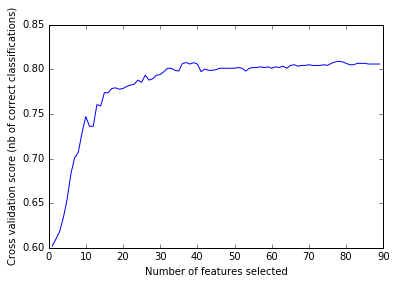

In [310]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
# # Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                            n_redundant=2, n_repeated=0, n_classes=8,
#                            n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
lg = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
              scoring='accuracy')
rfecv.fit(x, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
%matplotlib inline
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [298]:
y.value_counts()

1    763
0    514
Name: True_predictions, dtype: int64

In [ ]:
## Account for correlation between variables
## PCA ??  (find rank of PCA?) -- SCRI Plot (elbow plot)  
# - : forward stepwiser regression on eigen values
## P-value trace?

## 